In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
from pathlib import Path
from typing import  Optional, List, Tuple, Iterator
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from RaTag.core.dataIO import load_s2area
from RaTag.core.datatypes import Run
from RaTag.workflows.run_construction import initialize_run

In [4]:
from mimetypes import init


path_multi = Path('/Volumes/KINGSTON/RaTag_data/RUN18')
run = Run(
    run_id="RUN18",
    root_directory=path_multi,
    target_isotope="Th228",
    pressure=2.0,
    temperature=297.0,
    sampling_rate=5.0,
    drift_gap=1.4,
    el_gap=0.8,
    el_field=2375.0,
    sets=[]
)
run = initialize_run(run)


RUN INITIALIZATION

[1/3] Gas density...
  ✓ Gas density: 4.877e+19 cm⁻³

[2/3] Populating sets...
Detected multi-isotope files...
Detected multi-isotope files...
  Loaded: FieldScan_Gate0050_Anode1950 - 3800 files (182400 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0050_Anode1950 - 3800 files (182400 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
Detected multi-isotope files...
  Loaded: FieldScan_Gate0100_Anode2000 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0100_Anode2000 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
Detected multi-isotope files...
  Loaded: FieldScan_Gate0200_Anode2100 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
  Loaded: FieldScan_Gate0200_Anode2100 - 4000 files (192000 waveforms) [FastFrame (48 frames/file)]
Detected multi-isotope files...
Detected multi-isotope files...
  Loaded: FieldScan_Gate0300_Anode2200 - 400

In [60]:
s2_areas = []
for set in run.sets:
    s2_a = load_s2area(set)
    s2_areas.append(s2_a)

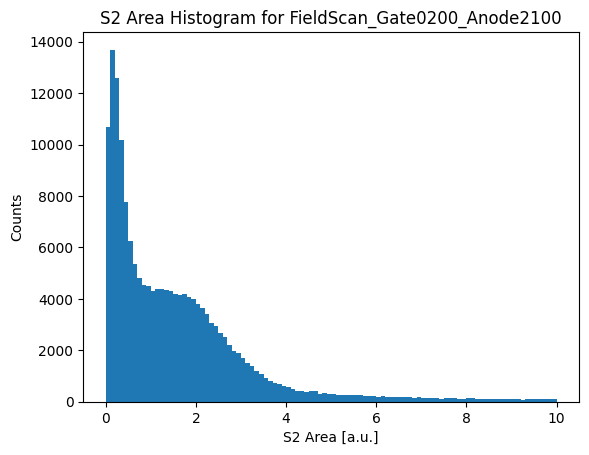

In [44]:

plt.hist(s2_a.areas, bins=100, range=(0, 10));
plt.gca().set(title='S2 Area Histogram for ' + set.source_dir.name,
              xlabel='S2 Area [a.u.]', ylabel='Counts');

## Two-Gaussian Fit Prototype

Let's fit a double Gaussian model to separate the background pileup peak from the signal peak.

In [39]:
from lmfit.models import GaussianModel
import numpy as np

# Load one of the failing sets for testing (e.g., set index 2)
test_s2 = s2_areas[2]
data = test_s2.areas

# Histogram parameters
bin_cuts = (0, 10)
nbins = 100

# Filter data
filtered = data[(data >= bin_cuts[0]) & (data <= bin_cuts[1])]
n, bins = np.histogram(filtered, bins=nbins, range=bin_cuts)
cbins = 0.5 * (bins[1:] + bins[:-1])

# Create two Gaussian models
gauss1 = GaussianModel(prefix='g1_')  # Background/pileup peak
gauss2 = GaussianModel(prefix='g2_')  # Signal peak

# Combined model
model = gauss1 + gauss2

# Initial parameter guesses
# Background peak: low position, narrow
# Signal peak: higher position, broader
params = model.make_params(
    g1_amplitude=n.max(),           # Background is tallest
    g1_center=0.5,                  # Low S2 area
    g1_sigma=0.3,                   # Narrow
    g2_amplitude=n.max() * 0.3,     # Signal is smaller
    g2_center=2.0,                  # Higher S2 area
    g2_sigma=1.0                    # Broader
)

# Constrain parameters to make physical sense
params['g1_center'].set(min=0, max=1.5)      # Background at low values
params['g2_center'].set(min=1.0, max=8.0)    # Signal at higher values
params['g1_sigma'].set(min=0.1, max=1.0)     # Background narrow
params['g2_sigma'].set(min=0.3, max=3.0)     # Signal can be broader

# Fit the model
result = model.fit(n, params, x=cbins)

# Print fit report
print(result.fit_report())

# Extract signal peak parameters (g2)
signal_mean = result.params['g2_center'].value
signal_sigma = result.params['g2_sigma'].value
signal_stderr = result.params['g2_center'].stderr
signal_ci95 = 1.96 * signal_stderr if signal_stderr else None

print(f"\n{'='*60}")
print(f"Signal Peak (g2) Results:")
print(f"  Mean: {signal_mean:.3f} ± {signal_ci95:.3f} mV·µs" if signal_ci95 else f"  Mean: {signal_mean:.3f} mV·µs")
print(f"  Sigma: {signal_sigma:.3f} mV·µs")
print(f"{'='*60}")

[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 98
    # data points      = 100
    # variables        = 6
    chi-square         = 2851181.67
    reduced chi-square = 30331.7199
    Akaike info crit   = 1037.80739
    Bayesian info crit = 1053.43841
    R-squared          = 0.99610841
[[Variables]]
    g1_amplitude:  4461.16174 +/- 177.928297 (3.99%) (init = 13687)
    g1_center:     0.18171762 +/- 0.00427924 (2.35%) (init = 0.5)
    g1_sigma:      0.19207398 +/- 0.00570619 (2.97%) (init = 0.3)
    g2_amplitude:  17201.5348 +/- 689.564764 (4.01%) (init = 4106.1)
    g2_center:     1.00000000 +/- 0.03063171 (3.06%) (init = 2)
    g2_sigma:      1.49041848 +/- 0.04875901 (3.27%) (init = 1)
    g1_fwhm:       0.45229965 +/- 0.01343705 (2.97%) == '2.3548200*g1_sigma'
    g1_height:     9265.94071 +/- 197.264283 (2.13%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:    

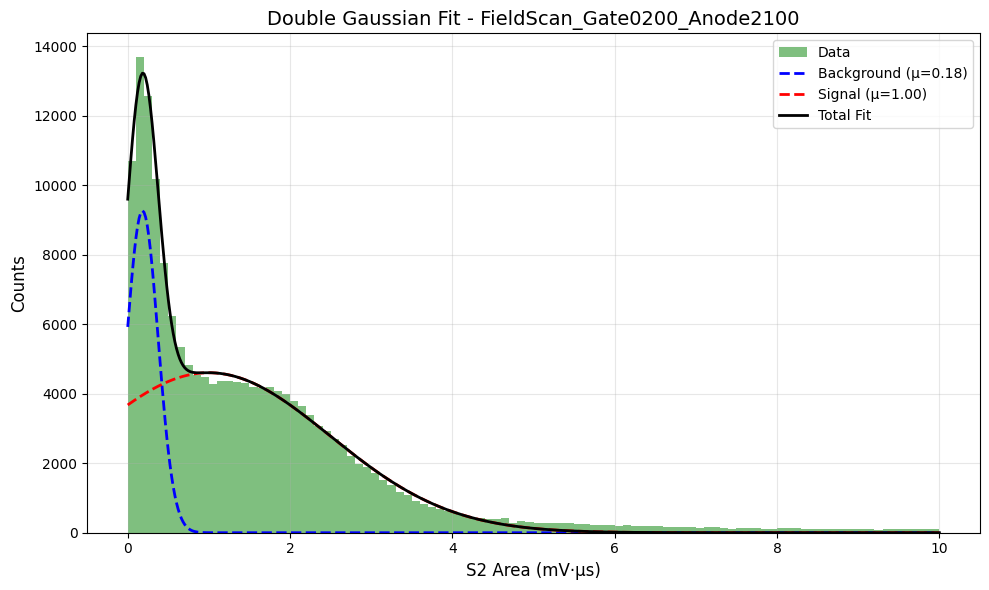

In [40]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(filtered, bins=nbins, range=bin_cuts, alpha=0.5, color='green', label='Data')

# Plot individual components
x_smooth = np.linspace(bin_cuts[0], bin_cuts[1], 500)
plt.plot(x_smooth, gauss1.eval(x=x_smooth, params=result.params), 
         '--', color='blue', linewidth=2, label=f'Background (μ={result.params["g1_center"].value:.2f})')
plt.plot(x_smooth, gauss2.eval(x=x_smooth, params=result.params), 
         '--', color='red', linewidth=2, label=f'Signal (μ={result.params["g2_center"].value:.2f})')

# Plot total fit
plt.plot(x_smooth, model.eval(x=x_smooth, params=result.params), 
         '-', color='black', linewidth=2, label='Total Fit')

plt.xlabel('S2 Area (mV·µs)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title(f'Double Gaussian Fit - {test_s2.source_dir.name}', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Crystal Ball Fit Approach

The long right tail suggests we need a Crystal Ball function instead of a Gaussian for the signal peak.

In [15]:
import lmfit

# Define vectorized Crystal Ball function for lmfit
def v_crystalball(x, N, beta, m, x0, sigma):
    """
    Vectorized Crystal Ball PDF for lmfit.
    N: normalization
    beta: tail parameter (typically positive)
    m: power-law exponent for tail (typically > 1)
    x0: peak location
    sigma: width parameter
    """
    absb = np.abs(beta)
    z = (x - x0) / sigma
    
    # Gaussian core
    gauss = np.exp(-0.5 * z**2)
    
    # Power-law tail
    A_tail = (m / absb)**m * np.exp(-0.5 * absb**2)
    B = m / absb - absb
    tail = A_tail / (B - z)**m
    
    # Use Gaussian for z > -beta, tail for z <= -beta
    return N * np.where(z > -absb, gauss, tail)

# Build model: Gaussian (background) + Crystal Ball (signal)
gauss_bg = lmfit.Model(lambda x, amp, cen, sig: amp * np.exp(-0.5 * ((x - cen) / sig)**2), 
                       prefix='bg_')
cb_signal = lmfit.Model(v_crystalball, prefix='sig_')
model_cb = gauss_bg + cb_signal

# Set up parameters
params_cb = model_cb.make_params(
    # Background Gaussian (low, narrow peak)
    bg_amp=n.max(),
    bg_cen=0.3,
    bg_sig=0.2,
    # Signal Crystal Ball (higher position, with tail)
    sig_N=n.max() * 0.4,
    sig_x0=1.5,
    sig_sigma=0.8,
    sig_beta=1.5,   # tail steepness
    sig_m=2.0       # tail power
)

# Constraints
params_cb['bg_cen'].set(min=0, max=1.0)
params_cb['bg_sig'].set(min=0.05, max=0.5)
params_cb['sig_x0'].set(min=0.8, max=5.0)
params_cb['sig_sigma'].set(min=0.2, max=2.5)
params_cb['sig_beta'].set(min=0.5, max=5.0)
params_cb['sig_m'].set(min=1.1, max=10.0)

# Fit
result_cb = model_cb.fit(n, params=params_cb, x=cbins)

# Print report
print(result_cb.fit_report())

# Extract signal peak parameters
signal_mean_cb = result_cb.params['sig_x0'].value
signal_sigma_cb = result_cb.params['sig_sigma'].value
signal_stderr_cb = result_cb.params['sig_x0'].stderr
signal_ci95_cb = 1.96 * signal_stderr_cb if signal_stderr_cb else None

print(f"\n{'='*60}")
print(f"Crystal Ball Signal Peak Results:")
print(f"  Peak position (x0): {signal_mean_cb:.3f} ± {signal_ci95_cb:.3f} mV·µs" if signal_ci95_cb else f"  Peak position: {signal_mean_cb:.3f} mV·µs")
print(f"  Width (sigma): {signal_sigma_cb:.3f} mV·µs")
print(f"  Tail β: {result_cb.params['sig_beta'].value:.3f}")
print(f"  Tail m: {result_cb.params['sig_m'].value:.3f}")
print(f"{'='*60}")

[[Model]]
    (Model(<lambda>, prefix='bg_') + Model(v_crystalball, prefix='sig_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 100
    # variables        = 8
    chi-square         = 2848738.82
    reduced chi-square = 30964.5524
    Akaike info crit   = 1041.72167
    Bayesian info crit = 1062.56304
    R-squared          = 0.99611174
##  Warning: uncertainties could not be estimated:
[[Variables]]
    bg_amp:     9219.00606 (init = 13687)
    bg_cen:     0.18203128 (init = 0.3)
    bg_sig:     0.19085277 (init = 0.2)
    sig_N:      4617.55645 (init = 5474.8)
    sig_beta:   2.91739594 (init = 1.5)
    sig_m:      1.42738049 (init = 2)
    sig_x0:     0.97712471 (init = 1.5)
    sig_sigma:  1.50517325 (init = 0.8)

Crystal Ball Signal Peak Results:
  Peak position: 0.977 mV·µs
  Width (sigma): 1.505 mV·µs
  Tail β: 2.917
  Tail m: 1.427


/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_26398/83874500.py:22: RuntimeWarning: invalid value encountered in power
  tail = A_tail / (B - z)**m


/var/folders/tb/zxwsw51n6_g6gs5lnxdv2bcr0000gn/T/ipykernel_25222/83874500.py:22: RuntimeWarning: invalid value encountered in power
  tail = A_tail / (B - z)**m


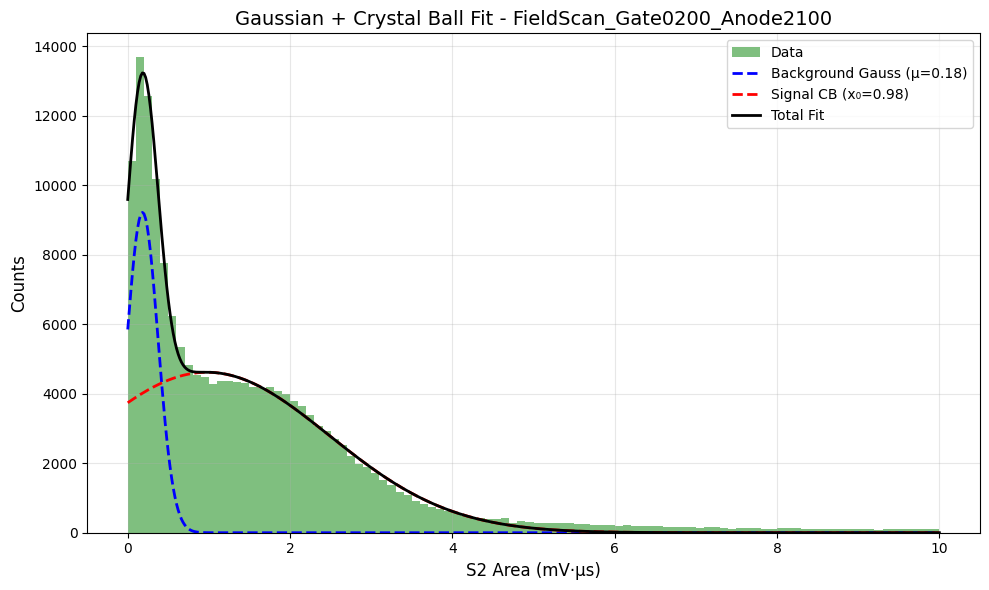

In [11]:
# Plot Crystal Ball fit results
plt.figure(figsize=(10, 6))

# Plot histogram
plt.hist(filtered, bins=nbins, range=bin_cuts, alpha=0.5, color='green', label='Data')

# Plot individual components
x_smooth = np.linspace(bin_cuts[0], bin_cuts[1], 500)

# Background Gaussian
bg_component = result_cb.eval_components(x=x_smooth)['bg_']
plt.plot(x_smooth, bg_component, 
         '--', color='blue', linewidth=2, 
         label=f'Background Gauss (μ={result_cb.params["bg_cen"].value:.2f})')

# Signal Crystal Ball
sig_component = result_cb.eval_components(x=x_smooth)['sig_']
plt.plot(x_smooth, sig_component, 
         '--', color='red', linewidth=2, 
         label=f'Signal CB (x₀={result_cb.params["sig_x0"].value:.2f})')

# Total fit
plt.plot(x_smooth, result_cb.eval(x=x_smooth), 
         '-', color='black', linewidth=2, label='Total Fit')

plt.xlabel('S2 Area (mV·µs)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title(f'Gaussian + Crystal Ball Fit - {test_s2.source_dir.name}', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Two-Stage Fitting Approach

Fit background first in restricted range, then fix it and fit signal peak.

## Helper: Remove Disconnected Bins

Function to automatically detect and remove isolated bins from histogram data.

In [7]:
def find_main_cluster(counts, threshold_fraction=0.01):
    """
    Find the main connected cluster of bins in a histogram.
    
    Removes isolated bins separated by gaps (bins with counts below threshold).
    
    Args:
        counts: Array of bin counts
        threshold_fraction: Bins with counts < threshold_fraction * max(counts) are considered "empty"
        
    Returns:
        Boolean mask indicating which bins belong to the main cluster
    """
    if len(counts) == 0:
        return np.zeros(len(counts), dtype=bool)
    
    threshold = threshold_fraction * counts.max()
    
    # Mark bins as "occupied" if above threshold
    occupied = counts > threshold
    
    # Find all connected regions
    # Label connected components (group of True values separated by False)
    from scipy.ndimage import label
    labeled, num_features = label(occupied)
    
    if num_features == 0:
        return occupied
    
    # Find the largest connected component
    component_sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]
    largest_component = np.argmax(component_sizes) + 1
    
    # Return mask for the largest component
    return labeled == largest_component

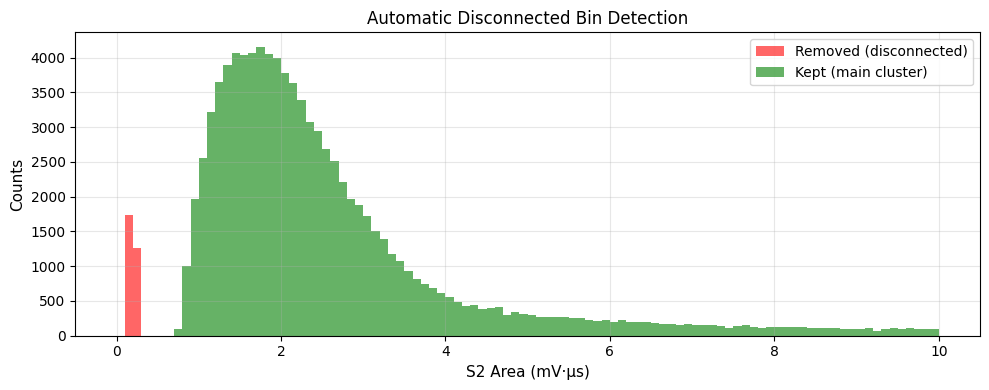

Bins removed: 7
Bins kept: 93


In [18]:
# Test the cluster finding function on our subtracted data
test_mask = find_main_cluster(n_subtracted, threshold_fraction=0.01)

# Visualize what gets kept vs removed
plt.figure(figsize=(10, 4))
plt.bar(cbins[~test_mask], n_subtracted[~test_mask], width=np.diff(bins)[0], 
        alpha=0.6, color='red', label='Removed (disconnected)')
plt.bar(cbins[test_mask], n_subtracted[test_mask], width=np.diff(bins)[0], 
        alpha=0.6, color='green', label='Kept (main cluster)')
plt.xlabel('S2 Area (mV·µs)', fontsize=11)
plt.ylabel('Counts', fontsize=11)
plt.title('Automatic Disconnected Bin Detection', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Bins removed: {(~test_mask).sum()}")
print(f"Bins kept: {test_mask.sum()}")

In [16]:
# STAGE 1: Fit background only in restricted range (0-1 mV·µs)
bg_cutoff = 1.0
bg_mask = cbins <= bg_cutoff
cbins_bg = cbins[bg_mask]
n_bg = n[bg_mask]

# Fit Gaussian to background only
gauss_bg_only = GaussianModel(prefix='bg_')
params_bg = gauss_bg_only.make_params(
    bg_amplitude=n_bg.max(),
    bg_center=0.3,
    bg_sigma=0.2
)
params_bg['bg_center'].set(min=0, max=bg_cutoff)
params_bg['bg_sigma'].set(min=0.05, max=0.5)

result_bg = gauss_bg_only.fit(n_bg, params=params_bg, x=cbins_bg)
print("STAGE 1: Background fit")
print(result_bg.fit_report())
print(f"\nBackground center: {result_bg.params['bg_center'].value:.3f} mV·µs")
print(f"Background sigma: {result_bg.params['bg_sigma'].value:.3f} mV·µs")

# STAGE 2: Fix background and fit signal on full range
# Subtract background to visualize
bg_full = gauss_bg_only.eval(x=cbins, params=result_bg.params)
n_subtracted = n - bg_full
n_subtracted = np.maximum(n_subtracted, 0)  # No negative counts

# Now fit just signal to the subtracted data
# Automatically find and keep only the main connected cluster
main_cluster_mask = find_main_cluster(n_subtracted, threshold_fraction=0.01)
signal_mask = main_cluster_mask & (cbins <= 5.0)  # Also limit upper range
cbins_sig = cbins[signal_mask]
n_sig = n_subtracted[signal_mask]

print(f"\nFound main cluster: {signal_mask.sum()} bins out of {len(cbins)} total")
print(f"Signal fit range: {cbins_sig.min():.2f} - {cbins_sig.max():.2f} mV·µs")

# Define RIGHT-tailed Crystal Ball (flip the sign of beta for right tail)
def v_crystalball_right(x, N, beta, m, x0, sigma):
    """Crystal Ball with RIGHT tail (for ionization signals)"""
    absb = np.abs(beta)
    z = (x - x0) / sigma
    gauss = np.exp(-0.5 * z**2)
    A_tail = (m / absb)**m * np.exp(-0.5 * absb**2)
    B = m / absb - absb
    tail = A_tail / (B + z)**m  # Note: +z instead of -z for RIGHT tail
    return N * np.where(z < absb, gauss, tail)  # Use tail for z >= beta

# Fit Crystal Ball to signal only (handles the right tail)
cb_sig = lmfit.Model(v_crystalball_right, prefix='sig_')
params_sig = cb_sig.make_params(
    sig_N=n_sig.max(),
    sig_x0=1.8,          # Initial guess based on subtracted data
    sig_sigma=0.5,
    sig_beta=1.0,        # tail steepness (for right side)
    sig_m=2.0            # tail power
)
params_sig['sig_x0'].set(min=1.2, max=3.5)
params_sig['sig_sigma'].set(min=0.2, max=1.5)
params_sig['sig_beta'].set(min=0.3, max=5.0)
params_sig['sig_m'].set(min=1.1, max=10.0)

result_sig = cb_sig.fit(n_sig, params=params_sig, x=cbins_sig)
print("\n" + "="*60)
print("STAGE 2: Crystal Ball signal fit (on background-subtracted data)")
print(result_sig.fit_report())

signal_mean_2stage = result_sig.params['sig_x0'].value
signal_sigma_2stage = result_sig.params['sig_sigma'].value
signal_stderr_2stage = result_sig.params['sig_x0'].stderr
signal_ci95_2stage = 1.96 * signal_stderr_2stage if signal_stderr_2stage else None

print(f"\n{'='*60}")
print(f"Two-Stage Crystal Ball Signal Peak Results:")
print(f"  Peak position (x₀): {signal_mean_2stage:.3f} ± {signal_ci95_2stage:.3f} mV·µs" if signal_ci95_2stage else f"  Peak position: {signal_mean_2stage:.3f} mV·µs")
print(f"  Width (σ): {signal_sigma_2stage:.3f} mV·µs")
print(f"  Tail β: {result_sig.params['sig_beta'].value:.3f}")
print(f"  Tail m: {result_sig.params['sig_m'].value:.3f}")
print(f"{'='*60}")

STAGE 1: Background fit
[[Model]]
    Model(gaussian, prefix='bg_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 10
    # variables        = 3
    chi-square         = 15432754.0
    reduced chi-square = 2204679.15
    Akaike info crit   = 148.494176
    Bayesian info crit = 149.401931
    R-squared          = 0.85977949
[[Variables]]
    bg_amplitude:  15193.0170 +/- 4818.13778 (31.71%) (init = 13687)
    bg_center:     0.06379402 +/- 0.17583457 (275.63%) (init = 0.3)
    bg_sigma:      0.50000000 +/- 0.11062403 (22.12%) (init = 0.2)
    bg_fwhm:       1.17741000 +/- 0.26049967 (22.12%) == '2.3548200*bg_sigma'
    bg_height:     12122.2743 +/- 6472.89415 (53.40%) == '0.3989423*bg_amplitude/max(1e-15, bg_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(bg_amplitude, bg_center) = -0.9699
    C(bg_amplitude, bg_sigma)  = -0.9663
    C(bg_center, bg_sigma)     = +0.9319

Background center: 0.064 mV·µs
Backgrou

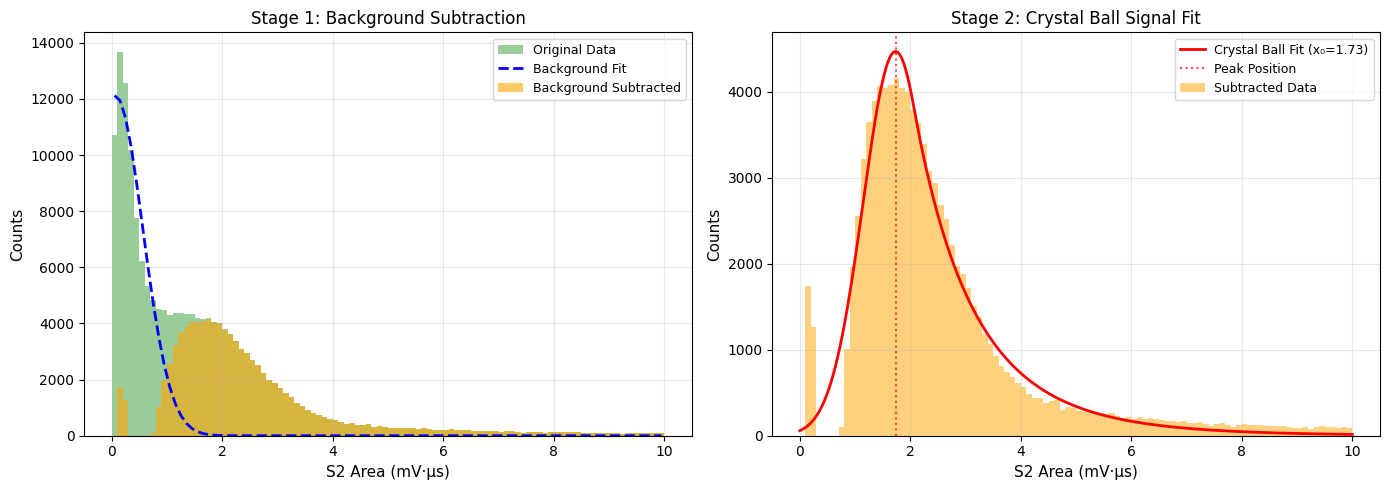

In [19]:
# Plot two-stage results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Background subtraction
ax1 = axes[0]
ax1.hist(filtered, bins=nbins, range=bin_cuts, alpha=0.4, color='green', label='Original Data')
ax1.plot(cbins, bg_full, 'b--', linewidth=2, label='Background Fit')
ax1.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.6, color='orange', label='Background Subtracted')
ax1.set_xlabel('S2 Area (mV·µs)', fontsize=11)
ax1.set_ylabel('Counts', fontsize=11)
ax1.set_title('Stage 1: Background Subtraction', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right plot: Crystal Ball signal fit on subtracted data
ax2 = axes[1]
ax2.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.5, color='orange', label='Subtracted Data')
x_smooth = np.linspace(bin_cuts[0], bin_cuts[1], 500)
sig_curve = cb_sig.eval(x=x_smooth, params=result_sig.params)
ax2.plot(x_smooth, sig_curve, 'r-', linewidth=2, 
         label=f'Crystal Ball Fit (x₀={signal_mean_2stage:.2f})')
ax2.axvline(signal_mean_2stage, color='red', linestyle=':', alpha=0.7, label='Peak Position')
ax2.set_xlabel('S2 Area (mV·µs)', fontsize=11)
ax2.set_ylabel('Counts', fontsize=11)
ax2.set_title('Stage 2: Crystal Ball Signal Fit', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison: Hardcoded vs Automatic Cluster Detection

Let's compare the original hardcoded approach with automatic cluster finding.

HARDCODED approach:
  Bins selected: 38
  Range: 1.25 - 4.95 mV·µs

AUTOMATIC approach:
  Bins selected: 43
  Range: 0.75 - 4.95 mV·µs

Difference: 5 bins


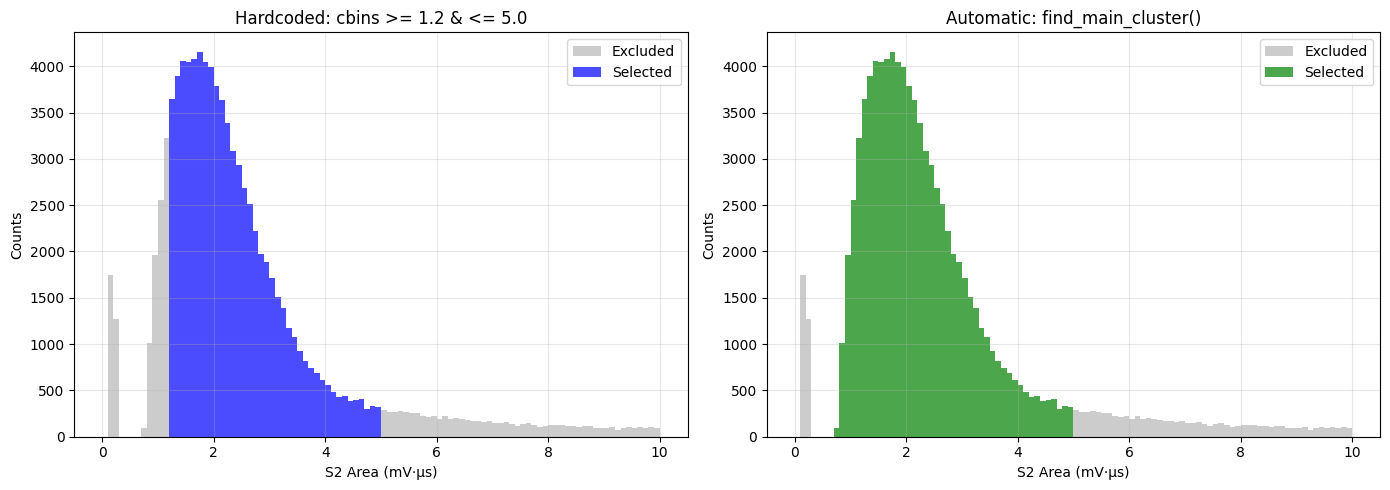

In [20]:
# ORIGINAL HARDCODED APPROACH (from before)
signal_mask_hardcoded = (cbins >= 1.2) & (cbins <= 5.0) & (n_subtracted > 0)
cbins_sig_old = cbins[signal_mask_hardcoded]
n_sig_old = n_subtracted[signal_mask_hardcoded]

# AUTOMATIC CLUSTER DETECTION APPROACH (current)
main_cluster_mask_auto = find_main_cluster(n_subtracted, threshold_fraction=0.01)
signal_mask_auto = main_cluster_mask_auto & (cbins <= 5.0)
cbins_sig_new = cbins[signal_mask_auto]
n_sig_new = n_subtracted[signal_mask_auto]

# Compare the two masks
print("HARDCODED approach:")
print(f"  Bins selected: {signal_mask_hardcoded.sum()}")
print(f"  Range: {cbins_sig_old.min():.2f} - {cbins_sig_old.max():.2f} mV·µs")
print(f"\nAUTOMATIC approach:")
print(f"  Bins selected: {signal_mask_auto.sum()}")
print(f"  Range: {cbins_sig_new.min():.2f} - {cbins_sig_new.max():.2f} mV·µs")
print(f"\nDifference: {signal_mask_auto.sum() - signal_mask_hardcoded.sum()} bins")

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Hardcoded selection
ax1 = axes[0]
ax1.bar(cbins[~signal_mask_hardcoded], n_subtracted[~signal_mask_hardcoded], 
        width=np.diff(bins)[0], alpha=0.4, color='gray', label='Excluded')
ax1.bar(cbins[signal_mask_hardcoded], n_subtracted[signal_mask_hardcoded], 
        width=np.diff(bins)[0], alpha=0.7, color='blue', label='Selected')
ax1.set_xlabel('S2 Area (mV·µs)')
ax1.set_ylabel('Counts')
ax1.set_title('Hardcoded: cbins >= 1.2 & <= 5.0')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Automatic selection
ax2 = axes[1]
ax2.bar(cbins[~signal_mask_auto], n_subtracted[~signal_mask_auto], 
        width=np.diff(bins)[0], alpha=0.4, color='gray', label='Excluded')
ax2.bar(cbins[signal_mask_auto], n_subtracted[signal_mask_auto], 
        width=np.diff(bins)[0], alpha=0.7, color='green', label='Selected')
ax2.set_xlabel('S2 Area (mV·µs)')
ax2.set_ylabel('Counts')
ax2.set_title('Automatic: find_main_cluster()')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Fit with HARDCODED approach (original working version)
cb_sig_old = lmfit.Model(v_crystalball_right, prefix='sig_')
params_sig_old = cb_sig_old.make_params(
    sig_N=n_sig_old.max(),
    sig_x0=1.8,
    sig_sigma=0.5,
    sig_beta=1.0,
    sig_m=2.0
)
params_sig_old['sig_x0'].set(min=1.2, max=3.5)
params_sig_old['sig_sigma'].set(min=0.2, max=1.5)
params_sig_old['sig_beta'].set(min=0.3, max=5.0)
params_sig_old['sig_m'].set(min=1.1, max=10.0)

result_sig_old = cb_sig_old.fit(n_sig_old, params=params_sig_old, x=cbins_sig_old)

# Fit with AUTOMATIC approach
cb_sig_new = lmfit.Model(v_crystalball_right, prefix='sig_')
params_sig_new = cb_sig_new.make_params(
    sig_N=n_sig_new.max(),
    sig_x0=1.8,
    sig_sigma=0.5,
    sig_beta=1.0,
    sig_m=2.0
)
params_sig_new['sig_x0'].set(min=1.2, max=3.5)
params_sig_new['sig_sigma'].set(min=0.2, max=1.5)
params_sig_new['sig_beta'].set(min=0.3, max=5.0)
params_sig_new['sig_m'].set(min=1.1, max=10.0)

result_sig_new = cb_sig_new.fit(n_sig_new, params=params_sig_new, x=cbins_sig_new)

# Compare results
print("="*70)
print("HARDCODED APPROACH RESULTS:")
print(f"  Peak position: {result_sig_old.params['sig_x0'].value:.3f} mV·µs")
print(f"  Width (σ): {result_sig_old.params['sig_sigma'].value:.3f} mV·µs")
print(f"  Tail β: {result_sig_old.params['sig_beta'].value:.3f}")
print(f"  Tail m: {result_sig_old.params['sig_m'].value:.3f}")
print(f"  Chi-squared: {result_sig_old.chisqr:.2f}")
print(f"  Reduced chi-squared: {result_sig_old.redchi:.2f}")

print("\n" + "="*70)
print("AUTOMATIC APPROACH RESULTS:")
print(f"  Peak position: {result_sig_new.params['sig_x0'].value:.3f} mV·µs")
print(f"  Width (σ): {result_sig_new.params['sig_sigma'].value:.3f} mV·µs")
print(f"  Tail β: {result_sig_new.params['sig_beta'].value:.3f}")
print(f"  Tail m: {result_sig_new.params['sig_m'].value:.3f}")
print(f"  Chi-squared: {result_sig_new.chisqr:.2f}")
print(f"  Reduced chi-squared: {result_sig_new.redchi:.2f}")
print("="*70)

HARDCODED APPROACH RESULTS:
  Peak position: 1.672 mV·µs
  Width (σ): 0.971 mV·µs
  Tail β: 1.059
  Tail m: 10.000
  Chi-squared: 105558.33
  Reduced chi-squared: 3198.74

AUTOMATIC APPROACH RESULTS:
  Peak position: 1.732 mV·µs
  Width (σ): 0.589 mV·µs
  Tail β: 0.549
  Tail m: 10.000
  Chi-squared: 2825752.65
  Reduced chi-squared: 74361.91


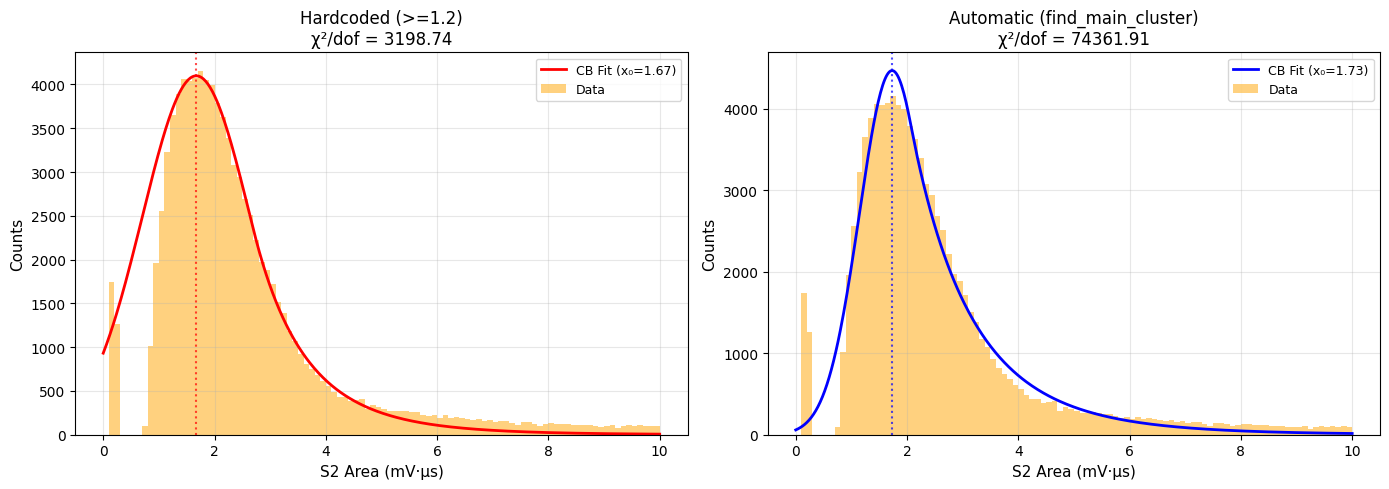

In [22]:
# Plot side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_smooth = np.linspace(bin_cuts[0], bin_cuts[1], 500)

# Left: Hardcoded approach
ax1 = axes[0]
ax1.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.5, color='orange', label='Data')
sig_curve_old = cb_sig_old.eval(x=x_smooth, params=result_sig_old.params)
ax1.plot(x_smooth, sig_curve_old, 'r-', linewidth=2, 
         label=f'CB Fit (x₀={result_sig_old.params["sig_x0"].value:.2f})')
ax1.axvline(result_sig_old.params['sig_x0'].value, color='red', linestyle=':', alpha=0.7)
ax1.set_xlabel('S2 Area (mV·µs)', fontsize=11)
ax1.set_ylabel('Counts', fontsize=11)
ax1.set_title(f'Hardcoded (>=1.2)\nχ²/dof = {result_sig_old.redchi:.2f}', fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Right: Automatic approach  
ax2 = axes[1]
ax2.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.5, color='orange', label='Data')
sig_curve_new = cb_sig_new.eval(x=x_smooth, params=result_sig_new.params)
ax2.plot(x_smooth, sig_curve_new, 'b-', linewidth=2, 
         label=f'CB Fit (x₀={result_sig_new.params["sig_x0"].value:.2f})')
ax2.axvline(result_sig_new.params['sig_x0'].value, color='blue', linestyle=':', alpha=0.7)
ax2.set_xlabel('S2 Area (mV·µs)', fontsize=11)
ax2.set_ylabel('Counts', fontsize=11)
ax2.set_title(f'Automatic (find_main_cluster)\nχ²/dof = {result_sig_new.redchi:.2f}', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Improved Approach: Background-Based Lower Bound

Use background fit statistics to automatically set the signal region start.

In [35]:
# Calculate smart lower bound based on background statistics
# Use background center + N*sigma as the cutoff
bg_center = result_bg.params['bg_center'].value
bg_sigma = result_bg.params['bg_sigma'].value
n_sigma = 2.5  # Number of sigmas away from background peak

lower_bound = bg_center + n_sigma * bg_sigma

print(f"Background fit parameters:")
print(f"  Center: {bg_center:.3f} mV·µs")
print(f"  Sigma: {bg_sigma:.3f} mV·µs")
print(f"\nSignal region lower bound: {bg_center:.3f} + {n_sigma}×{bg_sigma:.3f} = {lower_bound:.3f} mV·µs")
print(f"(Hardcoded was: 1.2 mV·µs)")

# Apply this criterion with cluster detection
main_cluster_mask_improved = find_main_cluster(n_subtracted, threshold_fraction=0.01)
signal_mask_improved = main_cluster_mask_improved & (cbins >= lower_bound) & (cbins <= 5.0)
cbins_sig_improved = cbins[signal_mask_improved]
n_sig_improved = n_subtracted[signal_mask_improved]

print(f"\nImproved approach:")
print(f"  Bins selected: {signal_mask_improved.sum()}")
print(f"  Range: {cbins_sig_improved.min():.2f} - {cbins_sig_improved.max():.2f} mV·µs")

Background fit parameters:
  Center: 0.064 mV·µs
  Sigma: 0.500 mV·µs

Signal region lower bound: 0.064 + 2.5×0.500 = 1.314 mV·µs
(Hardcoded was: 1.2 mV·µs)

Improved approach:
  Bins selected: 37
  Range: 1.35 - 4.95 mV·µs


In [36]:
# Fit with IMPROVED approach (background-based lower bound + cluster detection)
cb_sig_improved = lmfit.Model(v_crystalball_right, prefix='sig_')
params_sig_improved = cb_sig_improved.make_params(
    sig_N=n_sig_improved.max(),
    sig_x0=1.8,
    sig_sigma=0.5,
    sig_beta=1.0,
    sig_m=2.0
)
params_sig_improved['sig_x0'].set(min=lower_bound, max=3.5)
params_sig_improved['sig_sigma'].set(min=0.2, max=1.5)
params_sig_improved['sig_beta'].set(min=0.3, max=5.0)
params_sig_improved['sig_m'].set(min=1.1, max=10.0)

result_sig_improved = cb_sig_improved.fit(n_sig_improved, params=params_sig_improved, x=cbins_sig_improved)

print("="*70)
print("IMPROVED APPROACH RESULTS (bg_center + 3σ):")
print(f"  Peak position: {result_sig_improved.params['sig_x0'].value:.3f} mV·µs")
print(f"  Width (σ): {result_sig_improved.params['sig_sigma'].value:.3f} mV·µs")
print(f"  Tail β: {result_sig_improved.params['sig_beta'].value:.3f}")
print(f"  Tail m: {result_sig_improved.params['sig_m'].value:.3f}")
print(f"  Chi-squared: {result_sig_improved.chisqr:.2f}")
print(f"  Reduced chi-squared: {result_sig_improved.redchi:.2f}")
print("="*70)

# Compare all three
print("\n" + "="*70)
print("COMPARISON SUMMARY:")
print(f"  Hardcoded (>=1.2):    x₀={result_sig_old.params['sig_x0'].value:.3f}, χ²/dof={result_sig_old.redchi:.2f}")
print(f"  Automatic (cluster):  x₀={result_sig_new.params['sig_x0'].value:.3f}, χ²/dof={result_sig_new.redchi:.2f}")
print(f"  Improved (bg+3σ):     x₀={result_sig_improved.params['sig_x0'].value:.3f}, χ²/dof={result_sig_improved.redchi:.2f}")
print("="*70)

IMPROVED APPROACH RESULTS (bg_center + 3σ):
  Peak position: 1.648 mV·µs
  Width (σ): 0.997 mV·µs
  Tail β: 1.092
  Tail m: 10.000
  Chi-squared: 94598.37
  Reduced chi-squared: 2956.20

COMPARISON SUMMARY:
  Hardcoded (>=1.2):    x₀=1.672, χ²/dof=3198.74
  Automatic (cluster):  x₀=1.732, χ²/dof=74361.91
  Improved (bg+3σ):     x₀=1.648, χ²/dof=2956.20


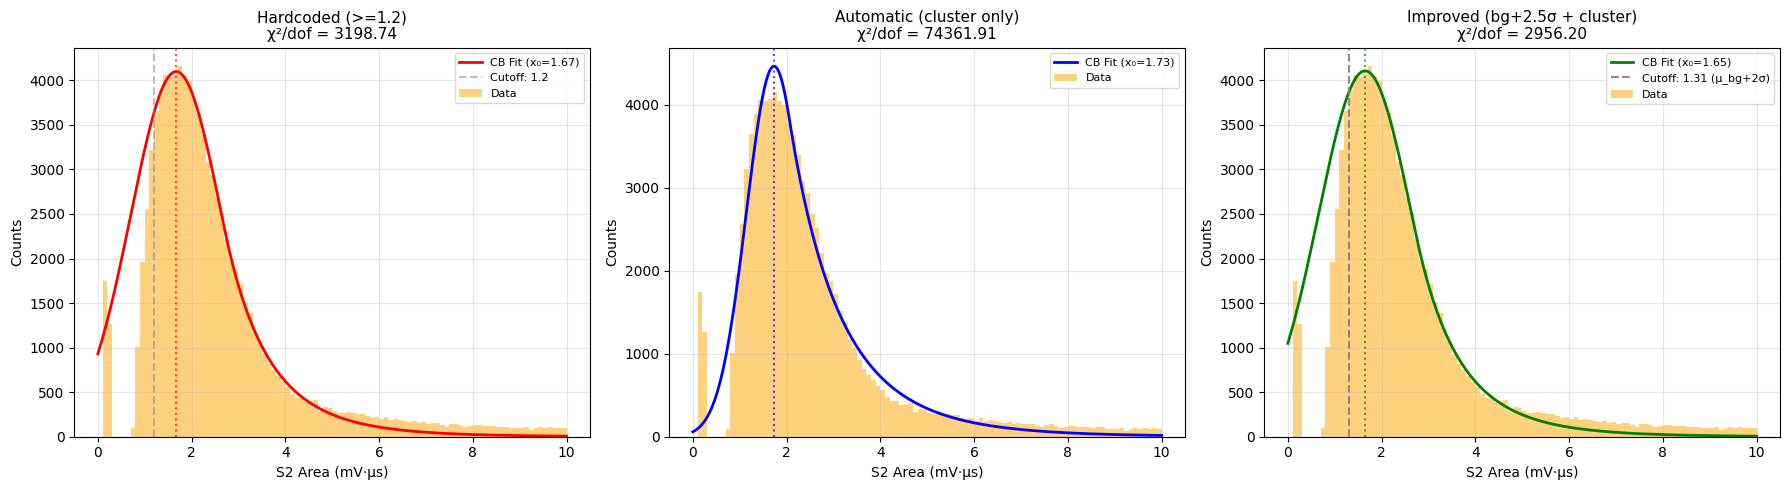

In [38]:
# Three-way comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_smooth = np.linspace(bin_cuts[0], bin_cuts[1], 500)

# Left: Hardcoded
ax1 = axes[0]
ax1.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.5, color='orange', label='Data')
sig_curve_old = cb_sig_old.eval(x=x_smooth, params=result_sig_old.params)
ax1.plot(x_smooth, sig_curve_old, 'r-', linewidth=2, 
         label=f'CB Fit (x₀={result_sig_old.params["sig_x0"].value:.2f})')
ax1.axvline(result_sig_old.params['sig_x0'].value, color='red', linestyle=':', alpha=0.7)
ax1.axvline(1.2, color='gray', linestyle='--', alpha=0.5, label='Cutoff: 1.2')
ax1.set_xlabel('S2 Area (mV·µs)', fontsize=10)
ax1.set_ylabel('Counts', fontsize=10)
ax1.set_title(f'Hardcoded (>=1.2)\nχ²/dof = {result_sig_old.redchi:.2f}', fontsize=11)
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

# Middle: Automatic (pure cluster)
ax2 = axes[1]
ax2.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.5, color='orange', label='Data')
sig_curve_new = cb_sig_new.eval(x=x_smooth, params=result_sig_new.params)
ax2.plot(x_smooth, sig_curve_new, 'b-', linewidth=2, 
         label=f'CB Fit (x₀={result_sig_new.params["sig_x0"].value:.2f})')
ax2.axvline(result_sig_new.params['sig_x0'].value, color='blue', linestyle=':', alpha=0.7)
ax2.set_xlabel('S2 Area (mV·µs)', fontsize=10)
ax2.set_ylabel('Counts', fontsize=10)
ax2.set_title(f'Automatic (cluster only)\nχ²/dof = {result_sig_new.redchi:.2f}', fontsize=11)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Right: Improved (background + cluster)
ax3 = axes[2]
ax3.bar(cbins, n_subtracted, width=np.diff(bins)[0], alpha=0.5, color='orange', label='Data')
sig_curve_improved = cb_sig_improved.eval(x=x_smooth, params=result_sig_improved.params)
ax3.plot(x_smooth, sig_curve_improved, 'g-', linewidth=2, 
         label=f'CB Fit (x₀={result_sig_improved.params["sig_x0"].value:.2f})')
ax3.axvline(result_sig_improved.params['sig_x0'].value, color='green', linestyle=':', alpha=0.7)
ax3.axvline(lower_bound, color='gray', linestyle='--', alpha=0.9, 
            label=f'Cutoff: {lower_bound:.2f} (μ_bg+2σ)')
ax3.set_xlabel('S2 Area (mV·µs)', fontsize=10)
ax3.set_ylabel('Counts', fontsize=10)
ax3.set_title(f'Improved (bg+2.5σ + cluster)\nχ²/dof = {result_sig_improved.redchi:.2f}', fontsize=11)
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Formalized Functions for Production Use

Functions to integrate into `core/fitting.py` for automatic S2 area fitting with background detection.

In [46]:
def v_crystalball_right(x, N, beta, m, x0, sigma):
    """
    Crystal Ball function with RIGHT tail for ionization signals.
    
    Parameters
    ----------
    x : array-like
        Input variable (S2 area values)
    N : float
        Normalization (amplitude)
    beta : float
        Tail steepness parameter (transition point)
    m : float
        Power-law exponent for tail (typically > 1)
    x0 : float
        Peak location
    sigma : float
        Width parameter (Gaussian core width)
        
    Returns
    -------
    array-like
        Crystal Ball function values
        
    Notes
    -----
    This version has the tail on the RIGHT side (z >= beta), appropriate
    for ionization signals where charge collection effects create a right tail.
    Standard Crystal Ball has LEFT tail for PMT resolution effects.
    """
    absb = np.abs(beta)
    z = (x - x0) / sigma
    
    # Gaussian core
    gauss = np.exp(-0.5 * z**2)
    
    # Power-law tail parameters
    A_tail = (m / absb)**m * np.exp(-0.5 * absb**2)
    B = m / absb - absb
    
    # RIGHT tail: use +z (not -z) in denominator
    tail = A_tail / (B + z)**m
    
    # Use Gaussian for z < beta, tail for z >= beta
    return N * np.where(z < absb, gauss, tail)


def find_main_cluster(counts, threshold_fraction=0.01):
    """
    Find the main connected cluster of bins in a histogram.
    
    Removes isolated bins separated by gaps (bins with counts below threshold).
    Useful for removing disconnected edge bins after background subtraction.
    
    Parameters
    ----------
    counts : array-like
        Array of histogram bin counts
    threshold_fraction : float, optional
        Bins with counts < threshold_fraction * max(counts) are considered "empty"
        Default is 0.01 (1% of maximum)
        
    Returns
    -------
    mask : ndarray of bool
        Boolean mask indicating which bins belong to the largest connected cluster
        
    Notes
    -----
    Uses scipy.ndimage.label for connected component analysis.
    """
    from scipy.ndimage import label
    
    if len(counts) == 0:
        return np.zeros(len(counts), dtype=bool)
    
    threshold = threshold_fraction * counts.max()
    
    # Mark bins as "occupied" if above threshold
    occupied = counts > threshold
    
    # Find all connected regions (groups of True values separated by False)
    labeled, num_features = label(occupied)
    
    if num_features == 0:
        return occupied
    
    # Find the largest connected component
    component_sizes = [(labeled == i).sum() for i in range(1, num_features + 1)]
    largest_component = np.argmax(component_sizes) + 1
    
    # Return mask for the largest component
    return labeled == largest_component

In [ ]:
def detect_background_peak(data, bin_cuts=(0, 10), nbins=100, bg_threshold=0.3):
    """
    Detect if histogram has significant background pileup peak at low values.
    
    Parameters
    ----------
    data : array-like
        S2 area values
    bin_cuts : tuple, optional
        (min, max) range for histogram
    nbins : int, optional
        Number of histogram bins
    bg_threshold : float, optional
        Threshold for detecting background peak presence
        If ratio of counts in [0, bg_threshold] to total counts > 0.15, 
        background subtraction is recommended
        
    Returns
    -------
    dict
        Dictionary with keys:
        - 'has_background': bool, whether background peak is significant
        - 'bg_fraction': float, fraction of counts in low-value region
        - 'recommendation': str, 'two_stage' or 'simple'
        
    Notes
    -----
    This function helps decide whether to use simple Crystal Ball fitting
    or two-stage fitting with background subtraction.
    """
    # Create histogram
    filtered = data[(data >= bin_cuts[0]) & (data <= bin_cuts[1])]
    n, bins = np.histogram(filtered, bins=nbins, range=bin_cuts)
    cbins = 0.5 * (bins[1:] + bins[:-1])
    
    # Calculate fraction of counts in low-value region
    low_mask = cbins <= bg_threshold
    bg_counts = n[low_mask].sum()
    total_counts = n.sum()
    bg_fraction = bg_counts / total_counts if total_counts > 0 else 0.0
    
    # Decision criterion: if >10% of counts are in low region, use two-stage
    has_background = bg_fraction > 0.1
    
    return {
        'has_background': has_background,
        'bg_fraction': bg_fraction,
        'recommendation': 'two_stage' if has_background else 'simple'
    }

In [48]:
def fit_s2_simple(data, bin_cuts=(0, 10), nbins=100):
    """
    Simple single Crystal Ball fit for S2 area distributions without background.
    
    Use this when there's no significant background pileup peak (e.g., low field conditions).
    
    Parameters
    ----------
    data : array-like
        S2 area values
    bin_cuts : tuple, optional
        (min, max) range for histogram fitting
    nbins : int, optional
        Number of histogram bins
        
    Returns
    -------
    dict
        Fit results with keys:
        - 'peak_position': float, fitted peak location (x0)
        - 'peak_stderr': float, standard error on peak position
        - 'sigma': float, width parameter
        - 'beta': float, tail steepness
        - 'm': float, tail power
        - 'chi2': float, chi-squared
        - 'redchi': float, reduced chi-squared
        - 'result': lmfit.ModelResult object
        - 'histogram': dict with 'bins', 'counts', 'bin_centers'
        
    Notes
    -----
    Fits right-tailed Crystal Ball directly to the full histogram.
    """
    # Create histogram
    filtered = data[(data >= bin_cuts[0]) & (data <= bin_cuts[1])]
    n, bins = np.histogram(filtered, bins=nbins, range=bin_cuts)
    cbins = 0.5 * (bins[1:] + bins[:-1])
    
    # Fit Crystal Ball to full distribution
    import lmfit
    cb_model = lmfit.Model(v_crystalball_right, prefix='sig_')
    
    # Initial parameters
    params = cb_model.make_params(
        sig_N=n.max(),
        sig_x0=1.5,
        sig_sigma=0.5,
        sig_beta=1.0,
        sig_m=2.0
    )
    
    # Constraints
    params['sig_x0'].set(min=0.5, max=bin_cuts[1] - 1.0)
    params['sig_sigma'].set(min=0.1, max=2.0)
    params['sig_beta'].set(min=0.3, max=5.0)
    params['sig_m'].set(min=1.1, max=10.0)
    
    # Fit
    result = cb_model.fit(n, params=params, x=cbins)
    
    return {
        'peak_position': result.params['sig_x0'].value,
        'peak_stderr': result.params['sig_x0'].stderr,
        'sigma': result.params['sig_sigma'].value,
        'beta': result.params['sig_beta'].value,
        'm': result.params['sig_m'].value,
        'chi2': result.chisqr,
        'redchi': result.redchi,
        'result': result,
        'histogram': {
            'bins': bins,
            'counts': n,
            'bin_centers': cbins
        }
    }

In [49]:
def fit_s2_two_stage(data, bin_cuts=(0, 10), nbins=100, bg_cutoff=1.0, 
                     n_sigma=2.5, upper_limit=5.0):
    """
    Two-stage fit for S2 area distributions with background pileup peak.
    
    Stage 1: Fit Gaussian to background in restricted range
    Stage 2: Subtract background, fit Crystal Ball to signal with smart region selection
    
    Parameters
    ----------
    data : array-like
        S2 area values
    bin_cuts : tuple, optional
        (min, max) range for histogram
    nbins : int, optional
        Number of histogram bins
    bg_cutoff : float, optional
        Upper limit for background-only fit region (default: 1.0 mV·µs)
    n_sigma : float, optional
        Number of sigmas above background peak for signal region lower bound
        (default: 2.5, recommended range: 2.0-3.0)
    upper_limit : float, optional
        Upper limit for signal fit region (default: 5.0 mV·µs)
        
    Returns
    -------
    dict
        Fit results with keys:
        - 'peak_position': float, signal peak location (x0)
        - 'peak_stderr': float, standard error on peak position
        - 'sigma': float, signal width parameter
        - 'beta': float, tail steepness
        - 'm': float, tail power
        - 'chi2': float, chi-squared
        - 'redchi': float, reduced chi-squared
        - 'bg_center': float, background peak center
        - 'bg_sigma': float, background width
        - 'lower_bound': float, calculated lower bound for signal region
        - 'result_bg': lmfit.ModelResult, background fit result
        - 'result_sig': lmfit.ModelResult, signal fit result
        - 'histogram': dict with 'bins', 'counts', 'bin_centers', 'subtracted'
        
    Notes
    -----
    Uses background statistics (μ_bg + n_sigma*σ_bg) to automatically determine
    signal region, avoiding hardcoded thresholds while maintaining robustness.
    """
    from lmfit.models import GaussianModel
    import lmfit
    
    # Create histogram
    filtered = data[(data >= bin_cuts[0]) & (data <= bin_cuts[1])]
    n, bins = np.histogram(filtered, bins=nbins, range=bin_cuts)
    cbins = 0.5 * (bins[1:] + bins[:-1])
    
    # ===== STAGE 1: Fit background in restricted range =====
    bg_mask = cbins <= bg_cutoff
    cbins_bg = cbins[bg_mask]
    n_bg = n[bg_mask]
    
    gauss_bg = GaussianModel(prefix='bg_')
    params_bg = gauss_bg.make_params(
        bg_amplitude=n_bg.max(),
        bg_center=0.3,
        bg_sigma=0.2
    )
    params_bg['bg_center'].set(min=0, max=bg_cutoff)
    params_bg['bg_sigma'].set(min=0.05, max=0.5)
    
    result_bg = gauss_bg.fit(n_bg, params=params_bg, x=cbins_bg)
    
    # Extract background parameters
    bg_center = result_bg.params['bg_center'].value
    bg_sigma = result_bg.params['bg_sigma'].value
    
    # ===== STAGE 2: Subtract background and fit signal =====
    # Subtract background from full histogram
    bg_full = gauss_bg.eval(x=cbins, params=result_bg.params)
    n_subtracted = np.maximum(n - bg_full, 0)  # No negative counts
    
    # Calculate smart lower bound based on background statistics
    lower_bound = bg_center + n_sigma * bg_sigma
    
    # Apply cluster detection + lower bound
    main_cluster_mask = find_main_cluster(n_subtracted, threshold_fraction=0.01)
    signal_mask = main_cluster_mask & (cbins >= lower_bound) & (cbins <= upper_limit)
    
    cbins_sig = cbins[signal_mask]
    n_sig = n_subtracted[signal_mask]
    
    # Fit Crystal Ball to signal
    cb_sig = lmfit.Model(v_crystalball_right, prefix='sig_')
    params_sig = cb_sig.make_params(
        sig_N=n_sig.max(),
        sig_x0=1.8,
        sig_sigma=0.5,
        sig_beta=1.0,
        sig_m=2.0
    )
    params_sig['sig_x0'].set(min=lower_bound, max=3.5)
    params_sig['sig_sigma'].set(min=0.2, max=1.5)
    params_sig['sig_beta'].set(min=0.3, max=5.0)
    params_sig['sig_m'].set(min=1.1, max=10.0)
    
    result_sig = cb_sig.fit(n_sig, params=params_sig, x=cbins_sig)
    
    return {
        'peak_position': result_sig.params['sig_x0'].value,
        'peak_stderr': result_sig.params['sig_x0'].stderr,
        'sigma': result_sig.params['sig_sigma'].value,
        'beta': result_sig.params['sig_beta'].value,
        'm': result_sig.params['sig_m'].value,
        'chi2': result_sig.chisqr,
        'redchi': result_sig.redchi,
        'bg_center': bg_center,
        'bg_sigma': bg_sigma,
        'lower_bound': lower_bound,
        'result_bg': result_bg,
        'result_sig': result_sig,
        'histogram': {
            'bins': bins,
            'counts': n,
            'bin_centers': cbins,
            'subtracted': n_subtracted
        }
    }

In [50]:
def fit_s2_area_auto(data, bin_cuts=(0, 10), nbins=100, **kwargs):
    """
    Automatic S2 area fitting with intelligent method selection.
    
    Automatically detects whether background subtraction is needed and uses
    the appropriate fitting method (simple Crystal Ball or two-stage).
    
    Parameters
    ----------
    data : array-like
        S2 area values
    bin_cuts : tuple, optional
        (min, max) range for histogram
    nbins : int, optional
        Number of histogram bins
    **kwargs : dict
        Additional parameters passed to fit_s2_simple or fit_s2_two_stage:
        - bg_threshold : float, threshold for background detection (default: 0.3)
        - bg_cutoff : float, upper limit for background fit (default: 1.0)
        - n_sigma : float, sigmas above background for signal region (default: 2.5)
        - upper_limit : float, upper limit for signal fit (default: 5.0)
        
    Returns
    -------
    dict
        Fit results (same structure as fit_s2_simple or fit_s2_two_stage)
        with additional key:
        - 'method': str, 'simple' or 'two_stage'
        
    Examples
    --------
    >>> result = fit_s2_area_auto(s2_areas)
    >>> print(f"Peak: {result['peak_position']:.3f} ± {result['peak_stderr']:.3f} mV·µs")
    >>> print(f"Method used: {result['method']}")
    >>> print(f"Chi²/dof: {result['redchi']:.2f}")
    
    Notes
    -----
    This is the recommended top-level function for S2 area fitting.
    It handles all cases automatically while providing detailed diagnostics.
    """
    # Detect if background subtraction is needed
    bg_threshold = kwargs.pop('bg_threshold', 0.3)
    detection = detect_background_peak(data, bin_cuts, nbins, bg_threshold)
    
    print(f"Background detection: {detection['bg_fraction']*100:.1f}% of counts in low region")
    print(f"Recommendation: {detection['recommendation']}")
    
    if detection['recommendation'] == 'two_stage':
        print("Using two-stage fitting with background subtraction...")
        result = fit_s2_two_stage(data, bin_cuts, nbins, **kwargs)
        result['method'] = 'two_stage'
    else:
        print("Using simple Crystal Ball fitting...")
        result = fit_s2_simple(data, bin_cuts, nbins)
        result['method'] = 'simple'
    
    return result

### Test the automatic fitting function

Let's test on both a low-field case (set 0, Cell 6) and high-field case (set 2, previous analysis).

In [51]:
# Test on low-field case (set 0 - should use simple method)
print("="*70)
print("TEST 1: Low-field case (set 0)")
print("="*70)
result_low = fit_s2_area_auto(s2_areas[0].areas)

print(f"\nResults:")
print(f"  Method: {result_low['method']}")
print(f"  Peak position: {result_low['peak_position']:.3f} ± {result_low['peak_stderr']:.3f} mV·µs")
print(f"  Width (σ): {result_low['sigma']:.3f} mV·µs")
print(f"  Chi²/dof: {result_low['redchi']:.2f}")
print("="*70)

TEST 1: Low-field case (set 0)
Background detection: 4.4% of counts in low region
Recommendation: simple
Using simple Crystal Ball fitting...

Results:
  Method: simple
  Peak position: 1.353 ± 0.009 mV·µs
  Width (σ): 0.892 mV·µs
  Chi²/dof: 17167.62


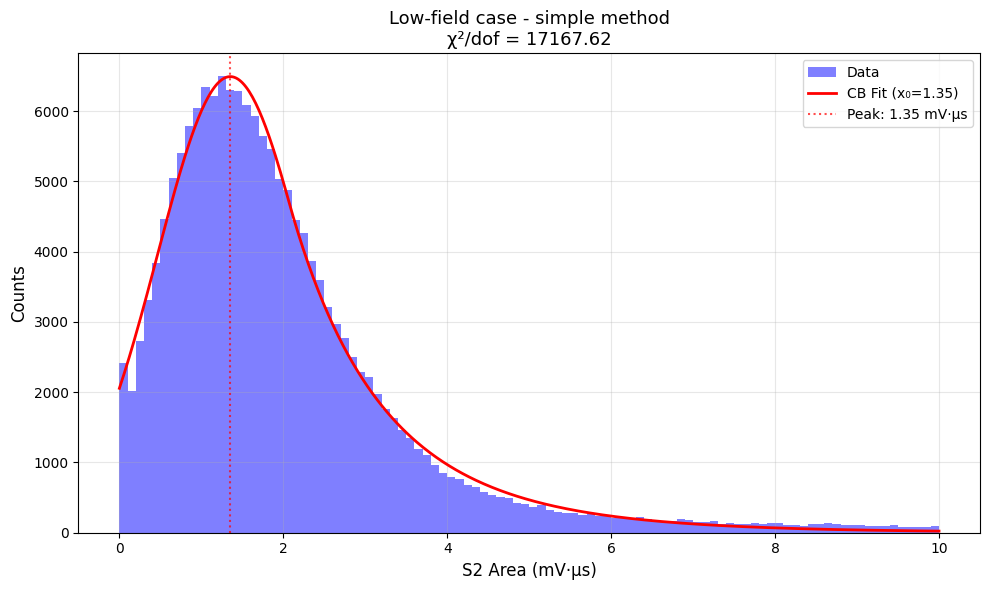

In [52]:
# Visualize low-field fit
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

hist_data = result_low['histogram']
ax.hist(s2_areas[0].areas, bins=hist_data['bins'], alpha=0.5, color='blue', label='Data')

x_smooth = np.linspace(0, 10, 500)
if result_low['method'] == 'simple':
    fit_curve = result_low['result'].eval(x=x_smooth)
    ax.plot(x_smooth, fit_curve, 'r-', linewidth=2, 
            label=f"CB Fit (x₀={result_low['peak_position']:.2f})")
    
ax.axvline(result_low['peak_position'], color='red', linestyle=':', alpha=0.7, 
           label=f"Peak: {result_low['peak_position']:.2f} mV·µs")
ax.set_xlabel('S2 Area (mV·µs)', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_title(f"Low-field case - {result_low['method']} method\nχ²/dof = {result_low['redchi']:.2f}", 
             fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
# Load set 2 for high-field test
s2_areas_highfield = []
for set in run.sets[1:2]:
    s2_a = load_s2area(set)
    s2_areas_highfield.append(s2_a)

# Test on high-field case (set 2 - should use two-stage method)
print("\n" + "="*70)
print("TEST 2: High-field case (set 2)")
print("="*70)
result_high = fit_s2_area_auto(s2_areas_highfield[0].areas)

print(f"\nResults:")
print(f"  Method: {result_high['method']}")
print(f"  Peak position: {result_high['peak_position']:.3f} ± {result_high['peak_stderr']:.3f} mV·µs")
print(f"  Width (σ): {result_high['sigma']:.3f} mV·µs")
print(f"  Chi²/dof: {result_high['redchi']:.2f}")
if result_high['method'] == 'two_stage':
    print(f"  Background: μ={result_high['bg_center']:.3f}, σ={result_high['bg_sigma']:.3f}")
    print(f"  Lower bound: {result_high['lower_bound']:.3f} mV·µs")
print("="*70)


TEST 2: High-field case (set 2)
Background detection: 16.7% of counts in low region
Recommendation: two_stage
Using two-stage fitting with background subtraction...

Results:
  Method: two_stage
  Peak position: 1.584 ± 0.043 mV·µs
  Width (σ): 0.737 mV·µs
  Chi²/dof: 3975.56
  Background: μ=0.334, σ=0.500
  Lower bound: 1.584 mV·µs


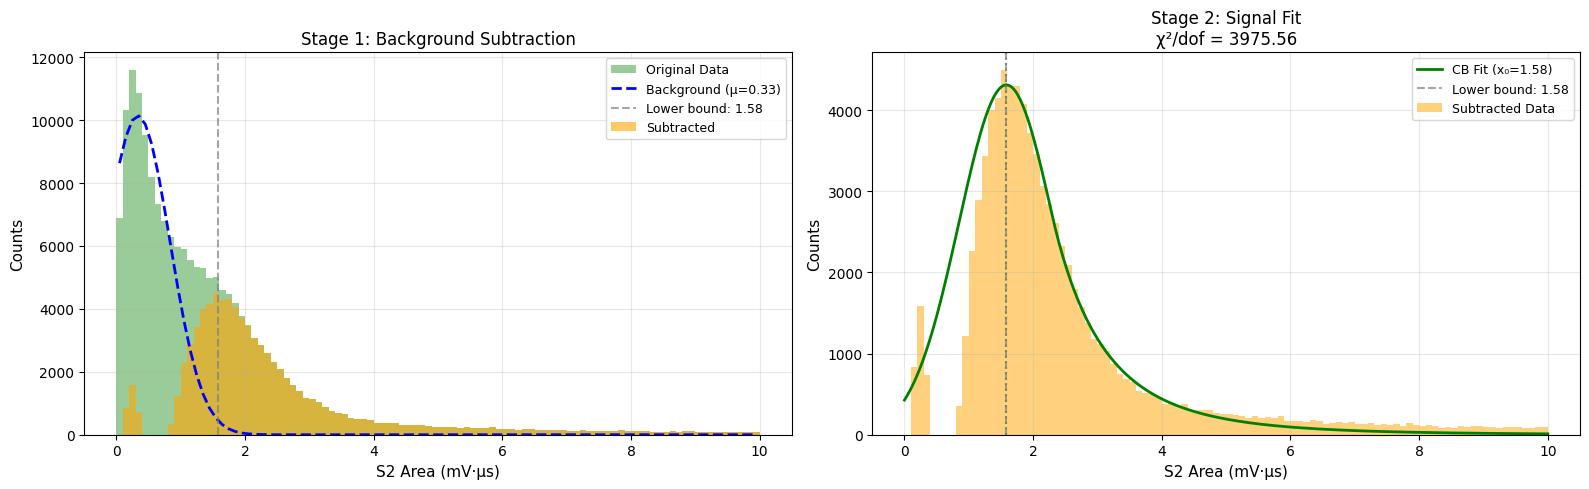

In [56]:
# Visualize high-field fit
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

hist_data = result_high['histogram']

if result_high['method'] == 'two_stage':
    # Left: Background subtraction
    ax1 = axes[0]
    ax1.hist(s2_areas_highfield[0].areas, bins=hist_data['bins'], 
             alpha=0.4, color='green', label='Original Data')
    bg_curve = result_high['result_bg'].eval(x=hist_data['bin_centers'])
    ax1.plot(hist_data['bin_centers'], bg_curve, 'b--', linewidth=2, 
             label=f"Background (μ={result_high['bg_center']:.2f})")
    ax1.bar(hist_data['bin_centers'], hist_data['subtracted'], 
            width=np.diff(hist_data['bins'])[0], alpha=0.6, color='orange', 
            label='Subtracted')
    ax1.axvline(result_high['lower_bound'], color='gray', linestyle='--', 
                alpha=0.7, label=f"Lower bound: {result_high['lower_bound']:.2f}")
    ax1.set_xlabel('S2 Area (mV·µs)', fontsize=11)
    ax1.set_ylabel('Counts', fontsize=11)
    ax1.set_title('Stage 1: Background Subtraction', fontsize=12)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Right: Signal fit
    ax2 = axes[1]
    ax2.bar(hist_data['bin_centers'], hist_data['subtracted'], 
            width=np.diff(hist_data['bins'])[0], alpha=0.5, color='orange', 
            label='Subtracted Data')
    x_smooth = np.linspace(0, 10, 500)
    sig_curve = result_high['result_sig'].eval(x=x_smooth)
    ax2.plot(x_smooth, sig_curve, 'g-', linewidth=2, 
             label=f"CB Fit (x₀={result_high['peak_position']:.2f})")
    ax2.axvline(result_high['peak_position'], color='green', linestyle=':', 
                alpha=0.7)
    ax2.axvline(result_high['lower_bound'], color='gray', linestyle='--', 
                alpha=0.7, label=f"Lower bound: {result_high['lower_bound']:.2f}")
    ax2.set_xlabel('S2 Area (mV·µs)', fontsize=11)
    ax2.set_ylabel('Counts', fontsize=11)
    ax2.set_title(f"Stage 2: Signal Fit\nχ²/dof = {result_high['redchi']:.2f}", 
                  fontsize=12)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Summary: Functions Ready for Integration

The following functions are ready to be integrated into `RaTag/core/fitting.py`:

1. **`v_crystalball_right(x, N, beta, m, x0, sigma)`** - Core fitting function
   - Right-tailed Crystal Ball for ionization signals
   
2. **`find_main_cluster(counts, threshold_fraction=0.01)`** - Helper function
   - Removes disconnected histogram bins using connected component analysis

3. **`detect_background_peak(data, bin_cuts, nbins, bg_threshold)`** - Decision function
   - Automatically detects if background subtraction is needed
   - Returns recommendation: 'simple' or 'two_stage'

4. **`fit_s2_simple(data, bin_cuts, nbins)`** - Simple fitting
   - Single Crystal Ball fit for clean distributions (low field)
   
5. **`fit_s2_two_stage(data, bin_cuts, nbins, bg_cutoff, n_sigma, upper_limit)`** - Advanced fitting
   - Two-stage fitting with background subtraction
   - Smart signal region selection using background statistics (μ_bg + 2.5σ)
   
6. **`fit_s2_area_auto(data, bin_cuts, nbins, **kwargs)`** - **RECOMMENDED TOP-LEVEL FUNCTION**
   - Automatically selects and applies the best fitting method
   - Returns standardized results dictionary
   - This is the function that should be called by the analysis pipeline

**Integration Note**: The automatic function (`fit_s2_area_auto`) should replace or augment the existing `fit_set_s2()` function in `core/fitting.py`.

In [57]:
def plot_s2_fit_result(result, data, set_name='', figsize=(16, 5)):
    """
    Plot S2 area fit results with appropriate visualization based on method.
    
    Parameters
    ----------
    result : dict
        Result dictionary from fit_s2_area_auto, fit_s2_simple, or fit_s2_two_stage
    data : array-like
        Original S2 area data
    set_name : str, optional
        Name/identifier for the dataset (for plot title)
    figsize : tuple, optional
        Figure size (width, height)
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated figure
    axes : array of matplotlib.axes.Axes
        The axes objects
        
    Notes
    -----
    For 'simple' method: creates single plot with data and fit
    For 'two_stage' method: creates two subplots showing background subtraction and signal fit
    """
    hist_data = result['histogram']
    
    if result['method'] == 'simple':
        # Single plot for simple method
        fig, ax = plt.subplots(1, 1, figsize=(figsize[0]//2, figsize[1]))
        
        ax.hist(data, bins=hist_data['bins'], alpha=0.5, color='blue', label='Data')
        
        x_smooth = np.linspace(hist_data['bins'][0], hist_data['bins'][-1], 500)
        fit_curve = result['result'].eval(x=x_smooth)
        ax.plot(x_smooth, fit_curve, 'r-', linewidth=2, 
                label=f"CB Fit (x₀={result['peak_position']:.2f})")
        
        ax.axvline(result['peak_position'], color='red', linestyle=':', alpha=0.7, 
                   label=f"Peak: {result['peak_position']:.2f} mV·µs")
        ax.set_xlabel('S2 Area (mV·µs)', fontsize=11)
        ax.set_ylabel('Counts', fontsize=11)
        ax.set_title(f"{set_name}\n{result['method']} method | χ²/dof = {result['redchi']:.2f}", 
                     fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        axes = np.array([ax])
        
    else:  # two_stage
        # Two subplots for two-stage method
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        
        # Left: Background subtraction
        ax1 = axes[0]
        ax1.hist(data, bins=hist_data['bins'], 
                 alpha=0.4, color='green', label='Original Data')
        bg_curve = result['result_bg'].eval(x=hist_data['bin_centers'])
        ax1.plot(hist_data['bin_centers'], bg_curve, 'b--', linewidth=2, 
                 label=f"Background (μ={result['bg_center']:.2f})")
        ax1.bar(hist_data['bin_centers'], hist_data['subtracted'], 
                width=np.diff(hist_data['bins'])[0], alpha=0.6, color='orange', 
                label='Subtracted')
        ax1.axvline(result['lower_bound'], color='gray', linestyle='--', 
                    alpha=0.7, label=f"Lower bound: {result['lower_bound']:.2f}")
        ax1.set_xlabel('S2 Area (mV·µs)', fontsize=11)
        ax1.set_ylabel('Counts', fontsize=11)
        ax1.set_title('Stage 1: Background Subtraction', fontsize=12)
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # Right: Signal fit
        ax2 = axes[1]
        ax2.bar(hist_data['bin_centers'], hist_data['subtracted'], 
                width=np.diff(hist_data['bins'])[0], alpha=0.5, color='orange', 
                label='Subtracted Data')
        x_smooth = np.linspace(hist_data['bins'][0], hist_data['bins'][-1], 500)
        sig_curve = result['result_sig'].eval(x=x_smooth)
        ax2.plot(x_smooth, sig_curve, 'g-', linewidth=2, 
                 label=f"CB Fit (x₀={result['peak_position']:.2f})")
        ax2.axvline(result['peak_position'], color='green', linestyle=':', 
                    alpha=0.7)
        ax2.axvline(result['lower_bound'], color='gray', linestyle='--', 
                    alpha=0.7, label=f"Lower bound: {result['lower_bound']:.2f}")
        ax2.set_xlabel('S2 Area (mV·µs)', fontsize=11)
        ax2.set_ylabel('Counts', fontsize=11)
        ax2.set_title(f"Stage 2: Signal Fit\nχ²/dof = {result['redchi']:.2f}", 
                      fontsize=12)
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # Add overall title
        fig.suptitle(set_name, fontsize=13, y=1.02)
    
    plt.tight_layout()
    return fig, axes

### Batch Processing: Test on Multiple Datasets

Iterate over all datasets (except the first one which has only a single peak) and apply automatic fitting.

In [64]:
len(s2_areas)

12

In [65]:
# Iterate over datasets (starting from index 1 to skip the single-peak case)
results_batch = []

for i, s2_data in enumerate(s2_areas[1:], start=1):
    set_name = s2_data.source_dir.name if hasattr(s2_data, 'source_dir') else f"Set {i}"
    
    print(f"\n{'='*80}")
    print(f"Processing: {set_name}")
    print('='*80)
    
    # Fit with automatic method selection
    result = fit_s2_area_auto(s2_data.areas)
    
    # Store results
    results_batch.append({
        'name': set_name,
        'index': i,
        'result': result,
        'data': s2_data.areas
    })
    
    print(f"\nFit Summary:")
    print(f"  Method: {result['method']}")
    print(f"  Peak: {result['peak_position']:.3f} ± {result['peak_stderr']:.3f} mV·µs")
    print(f"  Width: {result['sigma']:.3f} mV·µs")
    print(f"  χ²/dof: {result['redchi']:.2f}")
    if result['method'] == 'two_stage':
        print(f"  Background: μ={result['bg_center']:.3f}, σ={result['bg_sigma']:.3f}")
        print(f"  Lower bound: {result['lower_bound']:.3f} mV·µs")

print(f"\n{'='*80}")
print(f"Processed {len(results_batch)} datasets")
print('='*80)


Processing: FieldScan_Gate0100_Anode2000
Background detection: 16.7% of counts in low region
Recommendation: two_stage
Using two-stage fitting with background subtraction...

Fit Summary:
  Method: two_stage
  Peak: 1.584 ± 0.043 mV·µs
  Width: 0.737 mV·µs
  χ²/dof: 3975.56
  Background: μ=0.334, σ=0.500
  Lower bound: 1.584 mV·µs

Processing: FieldScan_Gate0200_Anode2100
Background detection: 21.3% of counts in low region
Recommendation: two_stage
Using two-stage fitting with background subtraction...

Fit Summary:
  Method: two_stage
  Peak: 1.648 ± 0.020 mV·µs
  Width: 0.997 mV·µs
  χ²/dof: 2956.20
  Background: μ=0.064, σ=0.500
  Lower bound: 1.314 mV·µs

Processing: FieldScan_Gate0300_Anode2200
Background detection: 20.2% of counts in low region
Recommendation: two_stage
Using two-stage fitting with background subtraction...

Fit Summary:
  Method: two_stage
  Peak: 1.876 ± 0.019 mV·µs
  Width: 1.207 mV·µs
  χ²/dof: 3267.71
  Background: μ=0.036, σ=0.500
  Lower bound: 1.286 mV·µ

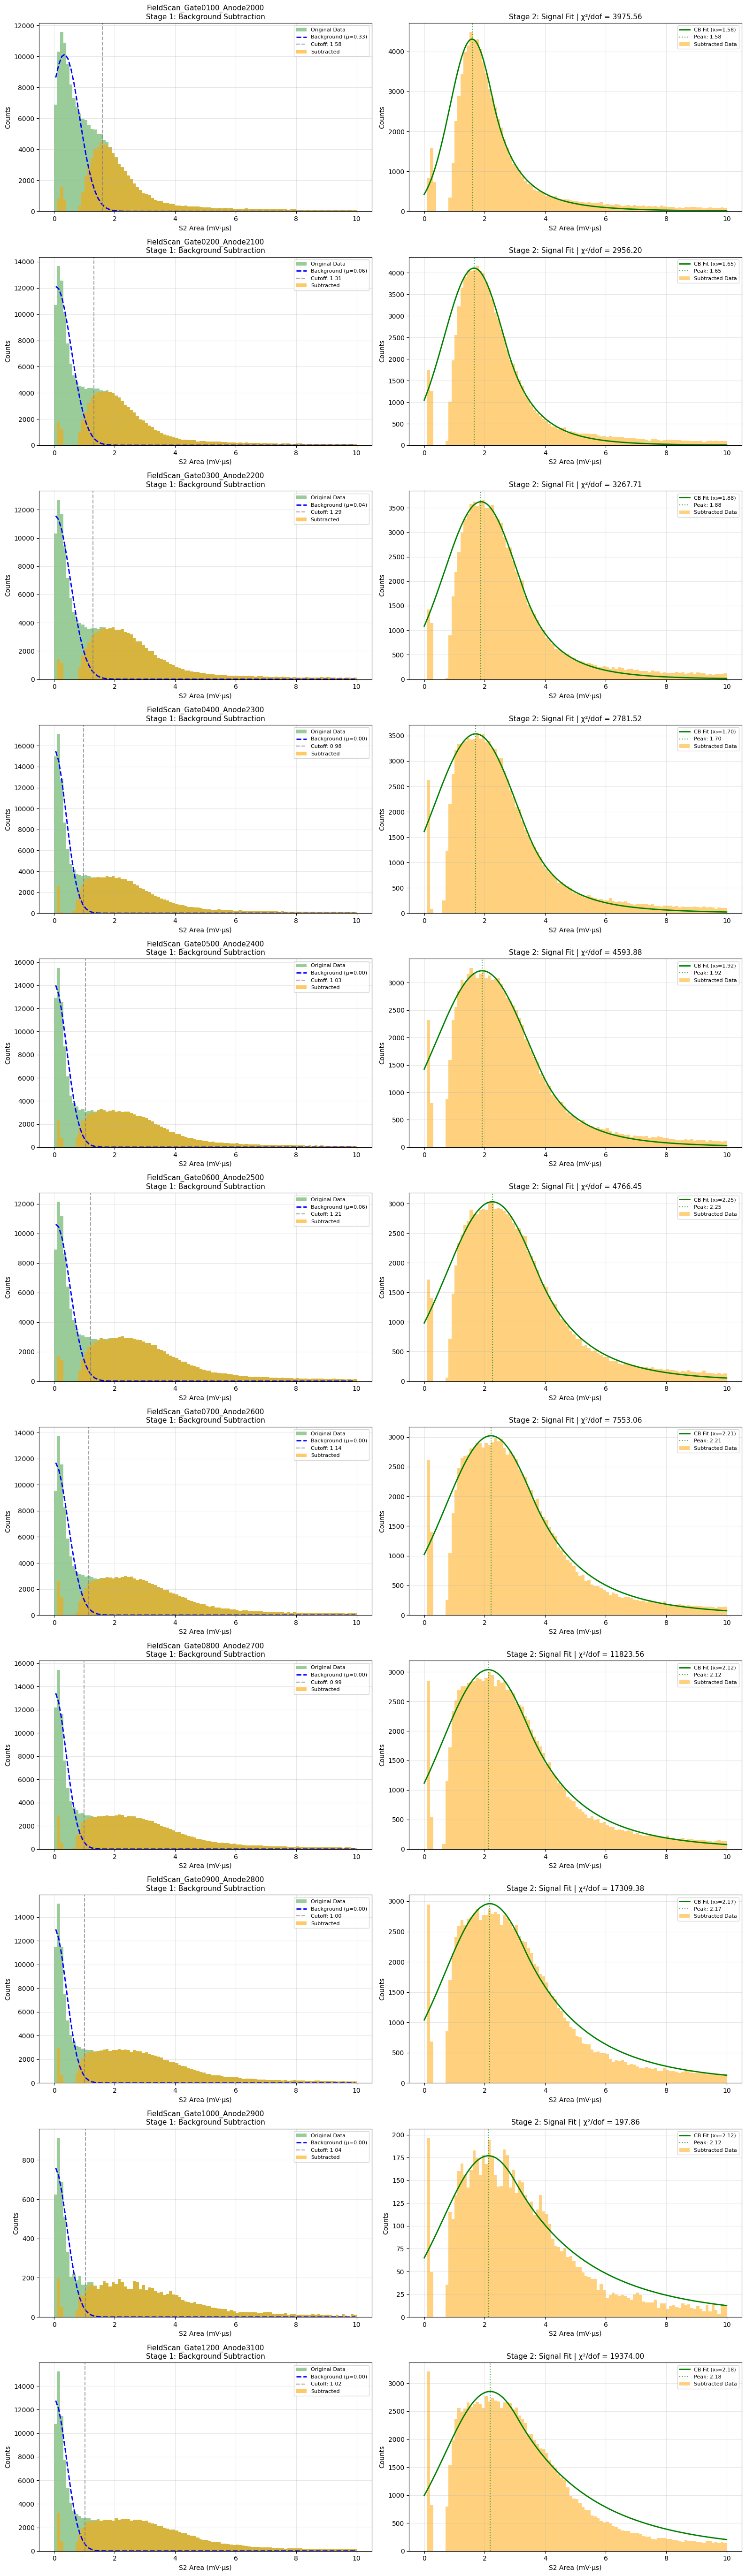

In [67]:
# Create a comprehensive figure with all fits
n_datasets = len(results_batch)

# Create subplots - 2 columns per dataset (for two-stage plots)
fig = plt.figure(figsize=(16, 5 * n_datasets))

for idx, batch_item in enumerate(results_batch):
    result = batch_item['result']
    data = batch_item['data']
    set_name = batch_item['name']
    
    if result['method'] == 'two_stage':
        # Two subplots for two-stage method
        hist_data = result['histogram']
        
        # Left subplot: Background subtraction
        ax1 = plt.subplot(n_datasets, 2, 2*idx + 1)
        ax1.hist(data, bins=hist_data['bins'], 
                 alpha=0.4, color='green', label='Original Data')
        bg_curve = result['result_bg'].eval(x=hist_data['bin_centers'])
        ax1.plot(hist_data['bin_centers'], bg_curve, 'b--', linewidth=2, 
                 label=f"Background (μ={result['bg_center']:.2f})")
        ax1.bar(hist_data['bin_centers'], hist_data['subtracted'], 
                width=np.diff(hist_data['bins'])[0], alpha=0.6, color='orange', 
                label='Subtracted')
        ax1.axvline(result['lower_bound'], color='gray', linestyle='--', 
                    alpha=0.7, label=f"Cutoff: {result['lower_bound']:.2f}")
        ax1.set_xlabel('S2 Area (mV·µs)', fontsize=10)
        ax1.set_ylabel('Counts', fontsize=10)
        ax1.set_title(f"{set_name}\nStage 1: Background Subtraction", fontsize=11)
        ax1.legend(fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # Right subplot: Signal fit
        ax2 = plt.subplot(n_datasets, 2, 2*idx + 2)
        ax2.bar(hist_data['bin_centers'], hist_data['subtracted'], 
                width=np.diff(hist_data['bins'])[0], alpha=0.5, color='orange', 
                label='Subtracted Data')
        x_smooth = np.linspace(hist_data['bins'][0], hist_data['bins'][-1], 500)
        sig_curve = result['result_sig'].eval(x=x_smooth)
        ax2.plot(x_smooth, sig_curve, 'g-', linewidth=2, 
                 label=f"CB Fit (x₀={result['peak_position']:.2f})")
        ax2.axvline(result['peak_position'], color='green', linestyle=':', 
                    alpha=0.7, label=f"Peak: {result['peak_position']:.2f}")
        ax2.set_xlabel('S2 Area (mV·µs)', fontsize=10)
        ax2.set_ylabel('Counts', fontsize=10)
        ax2.set_title(f"Stage 2: Signal Fit | χ²/dof = {result['redchi']:.2f}", 
                      fontsize=11)
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3)
    
    else:  # simple method
        # Single plot spanning both columns
        hist_data = result['histogram']
        ax = plt.subplot(n_datasets, 2, 2*idx + 1)
        
        ax.hist(data, bins=hist_data['bins'], alpha=0.5, color='blue', label='Data')
        x_smooth = np.linspace(hist_data['bins'][0], hist_data['bins'][-1], 500)
        fit_curve = result['result'].eval(x=x_smooth)
        ax.plot(x_smooth, fit_curve, 'r-', linewidth=2, 
                label=f"CB Fit (x₀={result['peak_position']:.2f})")
        ax.axvline(result['peak_position'], color='red', linestyle=':', alpha=0.7, 
                   label=f"Peak: {result['peak_position']:.2f}")
        ax.set_xlabel('S2 Area (mV·µs)', fontsize=10)
        ax.set_ylabel('Counts', fontsize=10)
        ax.set_title(f"{set_name}\n{result['method']} method | χ²/dof = {result['redchi']:.2f}", 
                     fontsize=11)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Results Summary Table

Summary of all fits with key metrics.

In [68]:
# Create summary table
summary_data = []
for batch_item in results_batch:
    result = batch_item['result']
    summary_data.append({
        'Dataset': batch_item['name'],
        'Method': result['method'],
        'Peak (mV·µs)': f"{result['peak_position']:.3f} ± {result['peak_stderr']:.3f}",
        'Width σ': f"{result['sigma']:.3f}",
        'χ²/dof': f"{result['redchi']:.2f}",
        'Bg Center': f"{result.get('bg_center', '-'):.3f}" if 'bg_center' in result else '-',
        'Lower Bound': f"{result.get('lower_bound', '-'):.3f}" if 'lower_bound' in result else '-'
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("FIT RESULTS SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)


FIT RESULTS SUMMARY
                     Dataset    Method  Peak (mV·µs) Width σ   χ²/dof Bg Center Lower Bound
FieldScan_Gate0100_Anode2000 two_stage 1.584 ± 0.043   0.737  3975.56     0.334       1.584
FieldScan_Gate0200_Anode2100 two_stage 1.648 ± 0.020   0.997  2956.20     0.064       1.314
FieldScan_Gate0300_Anode2200 two_stage 1.876 ± 0.019   1.207  3267.71     0.036       1.286
FieldScan_Gate0400_Anode2300 two_stage 1.704 ± 0.017   1.359  2781.52     0.000       0.978
FieldScan_Gate0500_Anode2400 two_stage 1.916 ± 0.021   1.500  4593.88     0.000       1.027
FieldScan_Gate0600_Anode2500 two_stage 2.251 ± 0.019   1.500  4766.45     0.062       1.209
FieldScan_Gate0700_Anode2600 two_stage 2.209 ± 0.023   1.500  7553.06     0.002       1.145
FieldScan_Gate0800_Anode2700 two_stage 2.121 ± 0.028   1.500 11823.56     0.000       0.988
FieldScan_Gate0900_Anode2800 two_stage 2.168 ± 0.035   1.500 17309.38     0.000       1.001
FieldScan_Gate1000_Anode2900 two_stage 2.124 ± 0.072   1.50

In [88]:
50/1.4/2

17.857142857142858